In [53]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *
from numpy import *

In [54]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
N = UNITS.newton

<Unit('newton')>

In [55]:
default_params = Params(
    x = 0 * m,
    y = 5000 * m,
    speed = 550 * m/s,
    mass = 900 * kg,
    g = 3.7 * m/s**2,
    diam = 3 * m,
    C_d = 0.3,
    rho = 1.2 * 0.006 * kg/m**3,
    t_end = 3600 * s,
    angle = -45 * degree,
    Thrust = 11000 * kg * m/s**2
)

,values
x,0 meter
y,5000 meter
speed,550.0 meter / second
mass,900 kilogram
g,3.7 meter / second ** 2
diam,3 meter
C_d,0.3
rho,0.0072 kilogram / meter ** 3
t_end,3600 second
angle,-45 degree


In [56]:
def make_system(params):
    """ Make a system object.
    
    params: Parameter object includes
     - x: initial x position (m)
     - y: initial y position (m)
     - speed: initial speed (m/s)
     
     - mass: rover mass (kg)
     - g: acceleration due to gravity (m/s^2)
     
     - diam: rover diameter (m)
     - C_d: coefficient of drag (unitless)
     - rho: air density at surface level (kg/m^3)
     
     - t_end: end time (s)
     
     - angle: entry angle (degree)
     - Thrust: thrust force (N)
    
    returns: System object includes
     - mass: rover mass (kg)
     - area: rover surface area (m^2)
     - g: acceleration due to gravity (m/s^2)
     - thrust: acceleration due to thrust (m/s^2)
     - C_d: coefficient of drag (unitless)
     - rho: air density at surface level (kg/m^3)
     - t_end: end time (s)
     - init: State object includes
      - pos: initial x,y position (Vector(m, m))
      - v: initial velocity (Vector(m/s, m/s))
    """
    
    unpack(params)
    
    area = np.pi * (diam/2)**2
    
    thrust = Thrust / mass
    
    theta = np.deg2rad(angle)
    vx, vy = Vector(*pol2cart(theta, speed))
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    return System(
        mass = mass,
        area = area,
        g = g,
        thrust = thrust,
        C_d = C_d,
        rho = rho,
        t_end = t_end,
        init = init
    )

In [57]:
make_system(default_params)

,values
mass,900 kilogram
area,7.0685834705770345 meter ** 2
g,3.7 meter / second ** 2
thrust,12.222222222222221 meter / second ** 2
C_d,0.3
rho,0.0072 kilogram / meter ** 3
t_end,3600 second
init,x 0 meter y ...


In [58]:
def drag_force(state, system):
    """Computes drag force in the opposite direction of velocity.
    
    state: State object with pos, v
    system: System object with area, C_d, rho
    
    returns: Vector drag force
    """
    
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    unpack(system)
    
    C_a = np.exp(-(pos.y/1000)/np.e)
    mag = -(rho * C_a) * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = mag * direction
    return f_drag

In [59]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, vx, vy)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (v.x, v.y, a.x, a.y)
    """
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    unpack(system)
  
    a_drag = drag_force(state, system) / mass
    a_grav = Vector(0, -g)
    a_thrust = Vector(0, thrust)
    
    a = a_grav + a_thrust + a_drag
    
    return v.x, v.y, a.x, a.y

In [63]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    S
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    pos = Vector(x,y)
    v = Vector(vx,vy)
    
    return pos.y

In [110]:
def landing_speed(init_speed, params):
    """Computes the speed at which the rover hits the ground for a given initial speed.
    
    init_speed: initial speed in m/s
    params: Params object
    
    returns: landing speed in m/s
    """
    params = Params(params, speed=init_speed)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    plot(results.index, results.y)
    final_v = Vector(get_last_value(results.vx), get_last_value(results.vy))
    print(final_v.y)
    final_speed = final_v.mag * m/s
    return final_speed

-146.6880137837511 dimensionless
Wall time: 128 ms


<Quantity(352.522397828345, 'meter / second')>

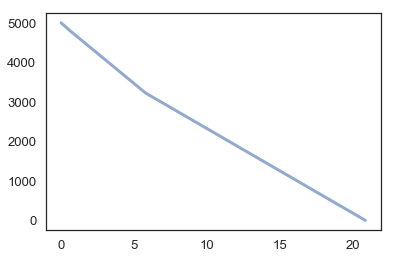

In [116]:
%time landing_speed(470 * m/s, default_params)

NameError: name 'results' is not defined